# Hyperparamter Tuning with SageMaker TensorFlow Container

This tutorial focuses on how to create a convolutional neural network model to train the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using **SageMaker TensorFlow container**. It leverages hyperparameter tuning to kick off multiple training jobs with different hyperparameter combinations, to find the one with best model training result.

The following diagram shows how you train and deploy a model with Amazon SageMaker:

<img src="https://docs.aws.amazon.com/sagemaker/latest/dg/images/sagemaker-architecture.png" />
     
     
The area labeled SageMaker highlights the two components of SageMaker: model training and model deployment.



To train a model in SageMaker, you create a training job. The training job includes the following information:

* The URL of the Amazon Simple Storage Service (Amazon S3) bucket where you've stored the training data.
* The compute resources that you want SageMaker to use for model training. Compute resources are ML compute instances that are managed by SageMaker.
* The URL of the S3 bucket where you want to store the output of the job.
* The Amazon Elastic Container Registry path where the training code is stored. For more information, see Docker Registry Paths and Example Code.

## Set Up the Environment 
Set up a few things before starting the workflow:

1. A boto session object to manage interactions with the Amazon SageMaker APIs. 
2. An execution role which will be passed to SageMaker for accessing your AWS resources

In [4]:
!pip install -q matplotlib

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

sess = sagemaker.Session()
role = get_execution_role()

## Data
Download the MNIST data from a public S3 bucket and save it in a temporary directory.

In [6]:
import logging
import boto3
from botocore.exceptions import ClientError

public_bucket = "sagemaker-sample-files"
local_data_dir = "/tmp/data"

# Download training and testing data from a public S3 bucket
def download_from_s3(data_dir="/tmp/data", train=True):
    """Download MNIST dataset and convert it to numpy array

    Args:
        data_dir (str): directory to save the data
        train (bool): download training set

    Returns:
        None
    """
    # project root
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if train:
        images_file = "train-images-idx3-ubyte.gz"
        labels_file = "train-labels-idx1-ubyte.gz"
    else:
        images_file = "t10k-images-idx3-ubyte.gz"
        labels_file = "t10k-labels-idx1-ubyte.gz"

    # download objects
    s3 = boto3.client("s3")
    bucket = public_bucket
    for obj in [images_file, labels_file]:
        key = os.path.join("datasets/image/MNIST", obj)
        dest = os.path.join(data_dir, obj)
        if not os.path.exists(dest):
            s3.download_file(bucket, key, dest)
    return


download_from_s3(local_data_dir, True)
download_from_s3(local_data_dir, False)

## Set Up a Tensorflow Training Job
A TensorFlow training job is defined by using the `TensorFlow` estimator class. It lets you run your training script on SageMaker infrastructure in a containerized environment. For more information on how to instantiate it, checkout [this example on setting up a basic training job](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_train.html#TensorFlow-Estimator).

In [7]:
est = TensorFlow(
    entry_point="train.py",
    source_dir="code",  # directory of your training script
    role=role,
    framework_version="2.3.1",
    model_dir="/opt/ml/model",
    py_version="py37",
    instance_type="ml.m5.4xlarge",
    instance_count=1,
    hyperparameters={
        "batch-size": 512,
        "epochs": 4,
    },
)

In [8]:
!pygmentize ./code/train.py

from __future__ import print_function

import argparse
import gzip
import json
import logging
import os
import sys
import traceback

import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Define the model object


class SmallConv(Model):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation="relu")
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


# Decode and preprocess data
def convert_to_numpy(data_dir, images_file, labels_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
   

## Set Up Channels for Training and Testing Data
Upload the MNIST data to the default bucket of your AWS account and pass the S3 URI as the channels of training and testing data for the `TensorFlow` estimator class. For more information about how to set up channels for input data, checkout [this example on setting up a basic training job](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_train.html#Set-up-channels-for-training-and-testing-data).

In [9]:
prefix = "mnist"
bucket = sess.default_bucket()
loc = sess.upload_data(path=local_data_dir, bucket=bucket, key_prefix=prefix)

channels = {"training": loc, "testing": loc}

## Set Up a Hyperparameter Tuning Job
Now that you have set up the training job and the input data channels, you are ready to train the model with hyperparameter search.

You will set up the hyperparameter tuning job with the following steps:
* Define the ranges of hyperparameters we plan to tune, in this example, we are tuning learning rate
* Define the objective metric for the tuning job to optimize
* Create a hyperparameter tuner with above setting, as well as tuning resource configurations 




For a typical ML model, there are three kinds of hyperparamters:

- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

Learning rate is a continuous variable, therefore, we define its range
by `ContinuousParameter`.

In [10]:
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner

hyperparamter_range = {"learning-rate": ContinuousParameter(1e-4, 1e-3)}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits average loss value and we will use it as the objective metric, we also set the `objective_type` to be `Minimize`, so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting.

In [11]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": "average test loss",
        # checkout line 161 in code/train.py
        "Regex": "Test Loss: ([0-9\\.]+)",
    }
]

Now, you'll create a `HyperparameterTuner` object. It takes the following parameters:
- The `TensorFlow` estimator you previously created
- Your hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [12]:
tuner = HyperparameterTuner(
    est,
    objective_metric_name,
    hyperparamter_range,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

tuner.fit(inputs=channels)

........................................................................................................!


## Deploy the Best Model
After training with hyperparameter optimization, you can deploy the best performing model (by the objective metric you defined) to a SageMaker endpoint. For more information about deploying a model to a SageMaker endpoint, checkout [this example on deploying a TensorFlow model](https://sagemaker-examples.readthedocs.io/en/latest/frameworks/tensorflow/get_started_mnist_deploy.html).

In [13]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge")


2021-08-18 16:09:45 Starting - Preparing the instances for training
2021-08-18 16:09:45 Downloading - Downloading input data
2021-08-18 16:09:45 Training - Training image download completed. Training in progress.
2021-08-18 16:09:45 Uploading - Uploading generated training model
2021-08-18 16:09:45 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



-------------!

## Evaluate
Now, you can evaluate the best performing model by invoking the endpoint with MNIST test set. The test data needs to be readily consumable by the model. So you need to arrange them into the correct shape that can be accepted by a TensorFlow model. Moreover, you need to normalize it so that the pixel values have mean 0 and standard deviation 1, since this is the convention you used to train the model.

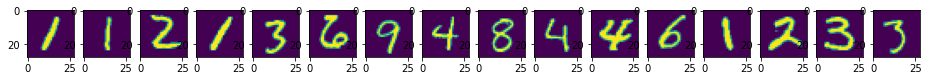

In [14]:
import random
import gzip
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


images_file = "t10k-images-idx3-ubyte.gz"


def read_mnist(data_dir, images_file):
    """Byte string to numpy arrays"""
    with gzip.open(os.path.join(data_dir, images_file), "rb") as f:
        images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return images


X = read_mnist(local_data_dir, images_file)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

# preprocess the data to be consumed by the model


def normalize(x, axis):
    eps = np.finfo(float).eps

    mean = np.mean(x, axis=axis, keepdims=True)
    # avoid division by zero
    std = np.std(x, axis=axis, keepdims=True) + eps
    return (x - mean) / std


samples = normalize(samples, axis=(1, 2))
samples = np.expand_dims(samples, axis=3)

In [15]:
predictions = predictor.predict(samples)["predictions"]

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)

print("Predictions: ", *predictions)

Predictions:  1 1 2 1 3 6 9 4 8 4 4 6 1 2 3 3


## (Optional) Clean Up
If you do not plan to use the endpoint, you should delete it to free up some computation resource.

In [16]:
# predictor.delete_endpoint()